# **Data Processing and Analysis with PySpark**

### **Overview**
In this workshop, we will explore how to use PySpark for data processing and analysis on Cloudera CML. PySpark, a Python API for Apache Spark, enables scalable, distributed computing for big data. Running on Cloudera CML ensures seamless integration with enterprise-level data platforms.

### **Dataset**
We will be working with the **NYC Yellow Taxi Trip Data**, a publicly available dataset that provides detailed records of taxi trips in New York City. The dataset includes information such as:
- **Pickup and drop-off locations** (latitude/longitude).
- **Trip duration and distance**.
- **Passenger count**.
- **Fare amount** and other payment details.
- **...**

### **Agenda**
- **Data Exploration**: Understand the structure and schema of the dataset.
- **Data Cleaning**: Handle missing values and inconsistent data.
- **Data Analysis**: Perform operations to derive insights, such as:
   - Calculating average trip distances.
   - Analyzing trip fares based on passenger counts.
   - Identifying patterns in pickup and drop-off locations.
- **Spark SQL**:
- **Build Machine Learning Model**: Build a supervised predictive machine learning model
- **Optimise model**: Improve model performance


### **Spark Session**

#### **Overview**
`SparkSession` is the primary entry point for interacting with Apache Spark, introduced in **Spark 2.0**. It unifies all Spark functionalities, including working with **RDDs**, **DataFrames**, **Datasets**, and **Spark SQL**, replacing older entry points like `SQLContext`, `HiveContext`, and `SparkContext`.

#### **Key Features**
1. **Unified Interface**: Provides a single API to handle structured and unstructured data processing.
2. **Cluster Connection**: Manages the connection to the cluster manager (e.g., YARN, Mesos, Kubernetes).
3. **Configuration Management**: Allows setting Spark configurations programmatically.
4. **Encapsulation**:
   - Includes `SparkContext`, accessible via `spark.sparkContext`.
   - Supports SQL capabilities with `spark.sql`.

#### **Key Methods**
- **Session Management**:
  - `builder`: Used to create and configure the `SparkSession`.
  - `stop()`: Terminates the session.
- **Data Operations**:
  - `read`/`write`: For loading and saving data in various formats.
  - `createDataFrame`: Creates DataFrames from RDDs or other data.

#### **Advantages**
- Simplifies Spark application development.
- Reduces boilerplate by combining multiple contexts.
- Standardizes APIs for structured and semi-structured data.

In [1]:
# Enable auto-reload
%load_ext autoreload
%autoreload 2

import pandas as pd

# Adjust pandas display settings
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)  # Adjust the display width to fit the content
pd.set_option("display.colheader_justify", "left")  # Align headers to the left
pd.set_option("display.max_colwidth", None)  # Don't truncate column content

In [2]:
import pprint
from pyspark.sql.functions import col, when, count
from pyspark.sql.types import DoubleType
from tabulate import tabulate
import pandas as pd
from utils import Utils
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import to_timestamp


In [3]:
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .appName("nyc-pyspark-analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "4") \
    .config("spark.driver.memory", "2g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "8") \
    .getOrCreate()

# Verify Spark Session
print(f"Spark Version: {spark.version}")
spark

Setting spark.hadoop.yarn.resourcemanager.principal to csso_msaleem


Spark Version: 3.3.0.1.20.7216.0-70


## Read Data

In [4]:
# Read the Parquet file into a DataFrame
file_path = "/home/cdsw/data/snappy/yellow_tripdata_2024-01_snappy.parquet"
df = spark.read.parquet(file_path) ## reading parquet file

from pyspark.sql.functions import col


# Display the schema of the DataFrame
print("Schema of the DataFrame:")
df.printSchema()

# Convert timestamp columns to string in PySpark 
df = df\
    .withColumn("tpep_pickup_datetime", col("tpep_pickup_datetime").cast("string"))\
    .withColumn("tpep_dropoff_datetime", col("tpep_dropoff_datetime").cast("string"))

# Show a sample of data (first 5 rows)
print("Sample Data:")
Utils.display(df.limit(5))

# Data dictionary:
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf


Schema of the DataFrame:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

Sample Data:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


### Data Cleaning

Data cleaning is a crucial step in data analysis to ensure the dataset is free from inconsistencies, missing values, or incorrect data. For the NYC taxi dataset, the cleaning process will involve the following steps:


#### **Handle Missing or Null Values**
   - Identify columns with null or missing values.
   - Decide on a strategy for handling them:
     - Fill with default values.

In [5]:
# Step 1: Handle Missing or Null Values
print("Step 1: Count of Null Values in Each Column:")
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

null_counts.show(vertical=True)

Step 1: Count of Null Values in Each Column:


-RECORD 0-----------------------
 VendorID              | 0      
 tpep_pickup_datetime  | 0      
 tpep_dropoff_datetime | 0      
 passenger_count       | 140162 
 trip_distance         | 0      
 RatecodeID            | 140162 
 store_and_fwd_flag    | 140162 
 PULocationID          | 0      
 DOLocationID          | 0      
 payment_type          | 0      
 fare_amount           | 0      
 extra                 | 0      
 mta_tax               | 0      
 tip_amount            | 0      
 tolls_amount          | 0      
 improvement_surcharge | 0      
 total_amount          | 0      
 congestion_surcharge  | 140162 
 Airport_fee           | 140162 



#### **Remove Duplicates**
   - Check if there are duplicate rows in the dataset and remove them.

In [6]:
count_with_dups = df.count()

df = df.dropDuplicates()

count_without_dups = df.count()

print(f"Count without duplicates :{count_with_dups}, count after removing duplicates:{count_without_dups}")


# Remove duplicates from some columns

# df_columns_dedup = df.dropDuplicates(["column1", "column2"])


Count without duplicates :2964624, count after removing duplicates:2964624


#### **Filter Out Invalid or Outlier Data**
   - Remove trips with:
     - Zero or negative trip distances.
     - Negative or zero `total_amount`.
   - Filter rows with invalid passenger counts (e.g., `passenger_count` <= 0).

In [7]:
df = df.filter(
    (col("trip_distance") > 0) &
    (col("total_amount") > 0) &
    (col("passenger_count") > 0)
)
df.count()

2724017

#### **Standardize Data Formats**
   - Convert categorical fields (e.g., `store_and_fwd_flag`) into consistent formats.
   - Ensure that timestamp fields are in the correct datetime format.

In [8]:
# Ensure `store_and_fwd_flag` is uppercase
df = df.withColumn("store_and_fwd_flag", when(col("store_and_fwd_flag") == "Y", "Y").otherwise("N"))
df.select("store_and_fwd_flag").show(5)

+------------------+
|store_and_fwd_flag|
+------------------+
|                 N|
|                 N|
|                 N|
|                 N|
|                 N|
+------------------+
only showing top 5 rows



#### **Additional Validations**
   - Check for logical inconsistencies, such as:
     - Pickup time being after the drop-off time.

In [9]:
# Ensure `trip_distance` is of type Double
df = df.withColumn("trip_distance", col("trip_distance").cast(DoubleType()))

# Step 5: Additional Validations
# Filter out rows where pickup time is after dropoff time
df = df.filter(col("tpep_pickup_datetime") < col("tpep_dropoff_datetime"))

print(f"After Filtering out incorrect pickup/dropoff time records, count:{df.count()}")

# Final schema and sample data after cleaning
print("Schema After Cleaning:")
df.printSchema()

print("Sample Data After Cleaning:")
Utils.display(df.limit(5))

After Filtering out incorrect pickup/dropoff time records, count:2723962
Schema After Cleaning:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

Sample Data After Cleaning:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-13 03:07:43,2024-01-13 03:18:04,2.0,1.63,1.0,N,79,211,1,12.1,1.0,0.5,4.28,0.0,1.0,21.38,2.5,0.0
1,2,2024-01-13 03:42:49,2024-01-13 04:02:49,3.0,5.92,1.0,N,249,256,1,28.2,1.0,0.5,0.00,0.0,1.0,33.20,2.5,0.0
2,2,2024-01-13 03:34:59,2024-01-13 03:47:46,1.0,3.31,1.0,N,211,246,1,17.0,1.0,0.5,1.00,0.0,1.0,23.00,2.5,0.0
3,2,2024-01-13 03:15:46,2024-01-13 03:17:50,1.0,0.48,1.0,N,79,4,1,4.4,1.0,0.5,1.88,0.0,1.0,11.28,2.5,0.0
4,1,2024-01-13 03:22:48,2024-01-13 03:36:36,1.0,3.30,1.0,N,148,229,1,17.0,3.5,0.5,1.00,0.0,1.0,23.00,2.5,0.0


### **Exploratory Data Analysis (EDA)**

#### **Distribution Analysis**
   - Visualize distributions of key metrics like `trip_distance`, `fare_amount`, and `trip_duration_minutes`.

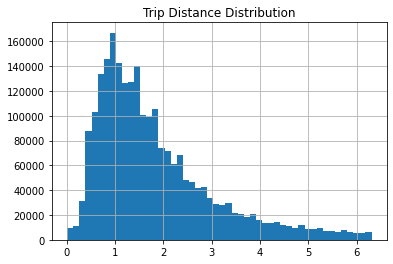

In [10]:
import matplotlib.pyplot as plt
data= df.toPandas()


# Remove extreme outliers for trip distance using IQR
Q1 = data['trip_distance'].quantile(0.25)
Q3 = data['trip_distance'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['trip_distance'] >= (Q1 - 1.5 * IQR)) & (data['trip_distance'] <= (Q3 + 1.5 * IQR))]

data['trip_distance'].hist(bins=50)
plt.title('Trip Distance Distribution')
plt.show()

#### **Time Trends**
   - Analyze how ride demand varies by hour, day, or month.

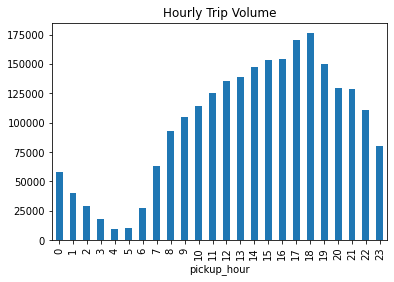

In [11]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], errors='coerce')
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], errors='coerce')


data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['pickup_day'] = data['tpep_pickup_datetime'].dt.day
data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
data['pickup_day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday

hourly_trends = data.groupby('pickup_hour').size()
hourly_trends.plot(kind='bar', title='Hourly Trip Volume')
plt.show()


#### **Correlation Analysis**
   - Check correlations between numeric columns like `fare_amount`, `trip_distance`, and `trip_duration_minutes`.

In [12]:
data['trip_duration_minutes'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60
print(data[['trip_distance', 'fare_amount', 'trip_duration_minutes']].corr())

                       trip_distance  fare_amount  trip_duration_minutes
trip_distance          1.000000       0.772742     0.156094             
fare_amount            0.772742       1.000000     0.169408             
trip_duration_minutes  0.156094       0.169408     1.000000             


#### **Heatmap of Pickup and Dropoff Locations**
   - Create heatmaps to visualize frequently used pickup and dropoff zones.

<Axes: xlabel='DOLocationID', ylabel='PULocationID'>

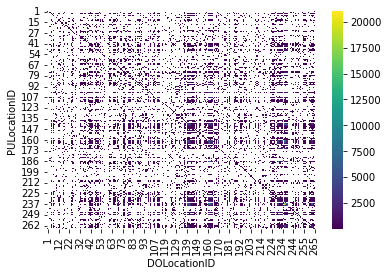

In [13]:
import seaborn as sns
sns.heatmap(data.groupby(['PULocationID', 'DOLocationID']).size().unstack(), cmap='viridis')

## Spark Dataframes

### **Data Exploration (further)**

#### **Describe Basic Statistics**


In [14]:
from pyspark.sql.functions import col, avg, sum, count, desc

# Describe basic statistics for numerical columns
print("Basic Statistics:")
df.describe(["trip_distance", "total_amount", "passenger_count"]).show()

Basic Statistics:


+-------+------------------+------------------+------------------+
|summary|     trip_distance|      total_amount|   passenger_count|
+-------+------------------+------------------+------------------+
|  count|           2723962|           2723962|           2723962|
|   mean|3.3026129476108985|27.409650832134876|1.3547186047382453|
| stddev|12.327432042874957|21.968201825628903|0.8447767579579177|
|    min|              0.01|               1.0|               1.0|
|    max|          15400.32|            2225.3|               9.0|
+-------+------------------+------------------+------------------+



#### **Distribution and Summaries**

In [15]:

# Distribution of trip_distance
print("Distribution of Trip Distance:")
from pyspark.sql.functions import min, max

# Calculate minimum and maximum fare amounts per VendorID
print("Minimum and Maximum Fare Amount per VendorID:")
df.groupBy("VendorID").agg(
    min("fare_amount").alias("min_fare"),
    max("fare_amount").alias("max_fare")
).show()

Distribution of Trip Distance:
Minimum and Maximum Fare Amount per VendorID:


+--------+--------+--------+
|VendorID|min_fare|max_fare|
+--------+--------+--------+
|       1|     0.0|   650.0|
|       2|     0.0|  2221.3|
+--------+--------+--------+



### **Group By and Aggregations**

#### **Revenue Analysis**

In [16]:
# Total revenue per VendorID
print("Total Revenue per VendorID:")
df.groupBy("VendorID").agg(sum("total_amount").alias("total_revenue")).show()

# Revenue contribution percentage per VendorID
print("Revenue Contribution Percentage per VendorID:")
df.groupBy("VendorID").agg(
    (sum("total_amount") / df.select(sum("total_amount")).first()[0] * 100).alias("revenue_percentage")
).show()

Total Revenue per VendorID:


+--------+--------------------+
|VendorID|       total_revenue|
+--------+--------------------+
|       1|1.6567504839999871E7|
|       2|5.8095342460001245E7|
+--------+--------------------+

Revenue Contribution Percentage per VendorID:


+--------+------------------+
|VendorID|revenue_percentage|
+--------+------------------+
|       1| 22.18975760920262|
|       2| 77.81024239079363|
+--------+------------------+



#### **Other Aggregations**

In [17]:
# Average trip distance and fare by RatecodeID
print("Average Trip Distance and Fare by RatecodeID:")
df.groupBy("RatecodeID").agg(
    avg("trip_distance").alias("avg_distance"),
    avg("fare_amount").alias("avg_fare")
).show()

# Average tip amount by passenger count
print("Average Tip Amount by Passenger Count:")
df.groupBy("passenger_count").agg(
    avg("tip_amount").alias("avg_tip")
).sort(desc("avg_tip")).show()

Average Trip Distance and Fare by RatecodeID:


+----------+------------------+------------------+
|RatecodeID|      avg_distance|          avg_fare|
+----------+------------------+------------------+
|       1.0|2.6087093096454987|15.793571558347919|
|       4.0|23.221026190083993|109.66423982869382|
|       3.0|17.413312780269063| 88.27899103139013|
|       2.0|  18.0265387825864|   69.981278947819|
|      99.0|  8.26642459542153| 33.52299185313525|
|       5.0| 9.994501585863182| 81.41562188491173|
|       6.0|              4.45|               2.5|
+----------+------------------+------------------+

Average Tip Amount by Passenger Count:


+---------------+------------------+
|passenger_count|           avg_tip|
+---------------+------------------+
|            8.0|13.671351351351353|
|            7.0|            10.968|
|            2.0|3.7567754206402606|
|            3.0|3.5692249246954186|
|            4.0| 3.468413380111295|
|            1.0|3.4166200524832453|
|            5.0|3.3936401849516535|
|            6.0| 3.343943630214205|
|            9.0|              3.05|
+---------------+------------------+



### **Time-Based Trends**

#### **Adding Time Columns**

In [18]:
from pyspark.sql.functions import year, month, dayofweek, hour

# Add columns for year, month, day of the week, and hour
df = df.withColumn("year", year("tpep_pickup_datetime")) \
       .withColumn("month", month("tpep_pickup_datetime")) \
       .withColumn("day_of_week", dayofweek("tpep_pickup_datetime")) \
       .withColumn("hour", hour("tpep_pickup_datetime"))

# Most popular pickup hours
print("Most Popular Pickup Hours:")
df.groupBy("hour").count().sort(desc("count")).show(5)

# Distribution of rides by day of the week
print("Distribution of Rides by Day of the Week:")
df.groupBy("day_of_week").count().sort("day_of_week").show(5)

# Monthly trend in total revenue
print("Monthly Trend in Total Revenue:")
df.groupBy("year", "month").agg(sum("total_amount").alias("total_revenue")).sort("year", "month").show(5)

Most Popular Pickup Hours:


+----+------+
|hour| count|
+----+------+
|  18|195924|
|  17|191271|
|  16|178416|
|  15|176982|
|  14|171278|
+----+------+
only showing top 5 rows

Distribution of Rides by Day of the Week:


+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|306425|
|          2|372444|
|          3|425927|
|          4|458809|
|          5|397493|
+-----------+------+
only showing top 5 rows

Monthly Trend in Total Revenue:


+----+-----+-------------------+
|year|month|      total_revenue|
+----+-----+-------------------+
|2002|   12|               10.5|
|2009|    1| 127.69000000000001|
|2023|   12|             224.62|
|2024|    1|7.466239402000436E7|
|2024|    2|              90.47|
+----+-----+-------------------+



### **Advanced Filtering**

In [19]:
# Trips longer than 10 miles with a tip greater than $10
print("Trips Longer than 10 Miles with Tips Greater than $10:")
Utils.display(df.filter((col("trip_distance") > 10) & (col("tip_amount") > 10)).limit(10))


Trips Longer than 10 Miles with Tips Greater than $10:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,year,month,day_of_week,hour
0,2,2024-01-13 05:41:38,2024-01-13 06:12:44,2.0,18.64,2.0,N,132,148,1,70.0,0.0,0.5,14.80,0.00,1.0,90.55,2.5,1.75,2024,1,7,5
1,2,2024-01-13 08:20:20,2024-01-13 08:49:25,1.0,16.67,2.0,N,132,162,1,70.0,0.0,0.5,16.54,6.94,1.0,99.23,2.5,1.75,2024,1,7,8
2,2,2024-01-13 09:08:00,2024-01-13 09:34:28,6.0,12.27,1.0,N,138,50,1,48.5,5.0,0.5,13.24,6.94,1.0,79.43,2.5,1.75,2024,1,7,9
3,2,2024-01-13 12:55:58,2024-01-13 13:25:01,1.0,13.08,1.0,N,138,234,1,52.0,5.0,0.5,13.94,6.94,1.0,83.63,2.5,1.75,2024,1,7,12
4,2,2024-01-13 14:12:15,2024-01-13 14:49:02,1.0,18.28,2.0,N,132,41,1,70.0,0.0,0.5,15.69,6.94,1.0,95.88,0.0,1.75,2024,1,7,14


In [20]:
# Peak hour trips (hour 7-9 and 16-18)
print("Peak Hour Trips (7-9 AM and 4-6 PM):")
Utils.display(df.filter( ((col("hour") >= 7) & (col("hour") <= 9)) | ((col("hour") >= 16) & (col("hour") <= 18))).limit(10))


Peak Hour Trips (7-9 AM and 4-6 PM):


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,year,month,day_of_week,hour
0,2,2024-01-24 16:24:37,2024-01-24 16:37:01,1.0,1.19,1.0,N,161,164,1,12.1,2.5,0.5,3.72,0.00,1.0,22.32,2.5,0.00,2024,1,4,16
1,2,2024-01-24 16:35:06,2024-01-24 16:41:39,1.0,1.03,1.0,N,164,107,2,7.9,2.5,0.5,0.00,0.00,1.0,14.40,2.5,0.00,2024,1,4,16
2,1,2024-01-24 16:13:39,2024-01-24 16:42:18,1.0,2.80,1.0,N,229,238,1,24.7,5.0,0.5,6.20,0.00,1.0,37.40,2.5,0.00,2024,1,4,16
3,2,2024-01-24 16:00:10,2024-01-24 17:05:48,2.0,20.23,3.0,N,162,1,1,107.7,2.5,0.0,33.40,22.38,1.0,166.98,0.0,0.00,2024,1,4,16
4,2,2024-01-24 16:53:50,2024-01-24 17:31:00,1.0,10.48,1.0,N,138,237,1,46.4,7.5,0.5,19.98,6.94,1.0,86.57,2.5,1.75,2024,1,4,16


In [21]:
# Trips with high total amounts but short distances
print("Trips with High Total Amounts but Short Distances:")
Utils.display(df.filter((col("total_amount") > 100) & (col("trip_distance") < 2)).limit(10))

Trips with High Total Amounts but Short Distances:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,year,month,day_of_week,hour
0,2,2024-01-17 00:05:41,2024-01-17 00:06:57,1.0,0.41,2.0,N,170,162,1,70.00,0.0,0.5,20.23,6.94,1.0,101.17,2.5,0.00,2024,1,4,0
1,1,2024-01-17 15:54:03,2024-01-17 15:54:34,1.0,0.30,5.0,N,132,132,1,87.00,0.0,0.0,17.60,0.00,1.0,105.60,0.0,0.00,2024,1,4,15
2,2,2024-01-17 21:36:44,2024-01-17 21:36:50,1.0,0.02,5.0,N,132,132,1,87.79,0.0,0.0,17.76,0.00,1.0,108.30,0.0,1.75,2024,1,4,21
3,2,2024-01-22 14:25:42,2024-01-22 14:25:53,1.0,0.09,2.0,N,235,47,1,70.00,0.0,0.5,70.00,0.00,1.0,141.50,0.0,0.00,2024,1,2,14
4,2,2024-01-20 06:36:28,2024-01-20 06:40:17,1.0,1.34,5.0,N,65,97,1,80.00,0.0,0.0,20.25,0.00,1.0,101.25,0.0,0.00,2024,1,7,6


## Spark UDF (User Defined Function)

### What is a Spark UDF?

A **Spark UDF (User Defined Function)** is a custom function that extends the capabilities of Spark’s built-in functions. UDFs allow you to define your own operations on data within a **Spark DataFrame** or **RDD**. These operations can be applied across rows in a distributed fashion and enable complex, domain-specific logic that is not natively supported by Spark.

### Purpose of Spark UDFs

- **Customization**: Allows you to write custom logic that is not part of Spark’s standard functions.
- **Extendibility**: Enables you to extend Spark with custom operations that meet your business or processing needs.
- **Encapsulation**: UDFs encapsulate complex logic, making it reusable and modular.
  
### When to Use Spark UDFs?

You might use Spark UDFs when:

- **Built-in functions are insufficient**: If the existing Spark functions don't cover your specific use case, you can write a UDF for more complex transformations (e.g., custom string manipulation, advanced mathematical operations).
- **Complex business logic**: If your transformation involves complex logic that requires multiple operations, external libraries, or custom rules.
- **Integration with external libraries**: UDFs let you use libraries such as `math`, `datetime`, `pandas`, and other custom Python functions within Spark jobs.

### How Spark UDFs Work

1. **Row-wise execution**: Spark UDFs are applied row-by-row. When you use a UDF, it will be executed on each row of the DataFrame or RDD.
2. **Distributed computation**: The UDF is serialized, distributed, and executed across multiple worker nodes in the Spark cluster. This allows Spark to perform large-scale distributed processing of data with your custom logic.
3. **Data transformation**: The UDF can be used to transform data in a DataFrame column by applying a custom function to each value in that column.

### Benefits of Spark UDFs

- **Flexibility**: You can implement custom business rules, data transformations, or any logic that goes beyond what’s provided by Spark's built-in functions.
- **Reusability**: Once a UDF is defined, it can be applied to multiple DataFrames or RDDs, improving code modularity.
- **Integration with Python/Scala**: UDFs allow you to integrate with Python/Scala libraries for more advanced computation or non-SQL logic.


In [28]:
from pyspark.sql.functions import udf, col, when, isnull
from pyspark.sql.types import DoubleType

# Step 1: Check for Null or Invalid Values
print("Checking for Null or Invalid Values:")
df_invalid = df.filter((col("trip_distance").isNull()) | (col("fare_amount").isNull()))
print("Invalid Rows:")
Utils.display(df_invalid)

# Drop rows with null values in trip_distance or fare_amount
df = df.filter((col("trip_distance").isNotNull()) & (col("fare_amount").isNotNull()))

# Step 2: Define UDF with Error Handling
def calculate_surcharge_safe(trip_distance, fare_amount):
    """
    Calculate surcharge based on trip_distance and fare_amount.
    Handles None or invalid values gracefully.
    """
    if trip_distance is None or fare_amount is None:
        return 0.0  # Default surcharge for invalid rows
    if trip_distance > 10:
        return fare_amount * 0.1
    else:
        return fare_amount * 0.05

# Register the UDF with Spark
surcharge_udf = udf(calculate_surcharge_safe, DoubleType())

# Step 3: Apply the UDF to Create a New Column
df_with_surcharge = df.withColumn(
    "custom_surcharge", surcharge_udf(col("trip_distance"), col("fare_amount"))
)

# Step 4: Display Results
print("Data with Custom Surcharge:")
Utils.display(df_with_surcharge.select("trip_distance", "fare_amount", "custom_surcharge").limit(10))

# Step 5: Check Schema to Confirm New Column
print("Updated Schema:")
df_with_surcharge.printSchema()


Checking for Null or Invalid Values:
Invalid Rows:
Data with Custom Surcharge:


Updated Schema:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)


## **Spark SQL Queries**

#### **Registering Table**

In [29]:
# Register DataFrame as a temporary table
df.createOrReplaceTempView("taxi_data")

#### **SQL Queries**

In [30]:
# Most frequent rate codes
print("Most Frequent Rate Codes:")
spark.sql("""
    SELECT RatecodeID, COUNT(*) AS frequency
    FROM taxi_data
    GROUP BY RatecodeID
    ORDER BY frequency DESC
""").show()

Most Frequent Rate Codes:


+----------+---------+
|RatecodeID|frequency|
+----------+---------+
|       1.0|  2581355|
|       2.0|    93444|
|      99.0|    27127|
|       5.0|     8828|
|       3.0|     7136|
|       4.0|     6071|
|       6.0|        1|
+----------+---------+



In [31]:
# Monthly revenue trends for each VendorID
print("Monthly Revenue Trends for Each VendorID:")
spark.sql("""
    SELECT year, month, VendorID, SUM(total_amount) AS total_revenue
    FROM taxi_data
    GROUP BY year, month, VendorID
    ORDER BY year, month, VendorID
""").show()

# Top 10 trips with highest tips
print("Top 10 Trips with Highest Tips:")
spark.sql("""
    SELECT VendorID, PULocationID, DOLocationID, tip_amount
    FROM taxi_data
    ORDER BY tip_amount DESC
    LIMIT 10
""").show()

Monthly Revenue Trends for Each VendorID:


+----+-----+--------+--------------------+
|year|month|VendorID|       total_revenue|
+----+-----+--------+--------------------+
|2002|   12|       2|                10.5|
|2009|    1|       2|  127.69000000000001|
|2023|   12|       2|              224.62|
|2024|    1|       1|1.6567504839999896E7|
|2024|    1|       2| 5.809488918000037E7|
|2024|    2|       2|               90.47|
+----+-----+--------+--------------------+

Top 10 Trips with Highest Tips:


+--------+------------+------------+----------+
|VendorID|PULocationID|DOLocationID|tip_amount|
+--------+------------+------------+----------+
|       2|         138|         226|     422.7|
|       2|         263|         107|     303.0|
|       1|         148|         265|     300.0|
|       2|         234|         132|     250.0|
|       2|          43|         236|    220.88|
|       2|          43|         107|     202.0|
|       2|          43|         237|     202.0|
|       1|         140|         263|    175.17|
|       1|          68|         265|     144.0|
|       2|         161|         265|     132.0|
+--------+------------+------------+----------+



### **Window Functions and Ranking**

In [32]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rank

# Window for partitioning by VendorID
windowSpec = Window.partitionBy("VendorID").orderBy(desc("total_amount"))

# Add row number for each VendorID's trips
print("Top Trips by VendorID (Row Number):")
Utils.display(df.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") <= 5).limit(5))

# Rank trips by total amount
print("Ranked Trips by Total Amount:")
Utils.display(df.withColumn("rank", rank().over(windowSpec)).limit(5))

Top Trips by VendorID (Row Number):


Ranked Trips by Total Amount:


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,year,month,day_of_week,hour,rank
0,1,2024-01-16 19:00:33,2024-01-16 23:07:48,1.0,210.2,5.0,N,132,265,1,650.0,0.00,0.0,0.0,38.68,1.0,689.68,0.0,0.00,2024,1,3,19,1
1,1,2024-01-11 23:23:01,2024-01-12 00:31:23,1.0,47.1,4.0,N,148,265,1,281.6,3.50,0.5,300.0,0.00,1.0,586.60,2.5,0.00,2024,1,5,23,2
2,1,2024-01-26 12:49:27,2024-01-26 16:01:22,1.0,153.2,1.0,N,132,265,2,550.4,1.75,0.5,0.0,20.32,1.0,573.97,0.0,1.75,2024,1,6,12,3
3,1,2024-01-09 14:14:49,2024-01-09 16:48:49,1.0,101.1,5.0,N,132,265,1,450.0,1.75,0.0,91.9,6.94,1.0,551.59,0.0,1.75,2024,1,3,14,4
4,1,2024-01-17 00:27:53,2024-01-17 00:28:14,1.0,14.0,5.0,N,265,265,1,515.0,0.00,0.0,0.0,0.00,1.0,516.00,0.0,0.00,2024,1,4,0,5


### **Additional Challenges**

1. **Challenge 1**: Find the most expensive trips and analyze their trip distances.
2. **Challenge 2**: Compare average tips between weekends and weekdays.
3. **Challenge 3**: Identify the most profitable hour for each VendorID.

# Machine Learning Model


### **Linear Regression Model**

#### **What is Linear Regression?**

Linear regression is a supervised learning algorithm used for predicting a continuous target variable based on one or more input features. The model assumes a **linear relationship** between the independent variables (predictors) and the dependent variable (target).

#### **Types of Linear Regression**

1. **Simple Linear Regression**:  
   Predicts a target variable based on a single feature. The relationship is modeled as:
   \[
   y = \beta_0 + \beta_1 x + \epsilon
   \]
   Where:
   - \(y\) is the target variable.
   - \(x\) is the feature (independent variable).
   - \(\beta_0\) is the intercept.
   - \(\beta_1\) is the coefficient (slope).
   - \(\epsilon\) is the error term.

2. **Multiple Linear Regression**:  
   Extends simple linear regression to multiple features:
   \[
   y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
   \]
   Where:
   - \(x_1, x_2, \dots, x_n\) are the multiple input features.

#### **Purpose of Linear Regression**

Linear regression aims to find the best-fitting line (or hyperplane in multiple regression) that minimizes the difference between predicted and actual values. This line is determined by finding the optimal values for the model parameters (intercept and coefficients), typically using **Ordinary Least Squares (OLS)**.

#### **Key Components**

1. **Intercept (\(\beta_0\))**:  
   The value of the target variable when all input features are zero.

2. **Coefficients (\(\beta_1, \beta_2, \dots\))**:  
   These represent the effect or influence of each feature on the target variable.

3. **Error Term (\(\epsilon\))**:  
   The difference between the predicted value and the actual value.

#### **Assumptions of Linear Regression**

For the linear regression model to be valid, the following assumptions should ideally hold:
1. **Linearity**: The relationship between the predictors and the target is linear.
2. **Independence**: The residuals (errors) are independent.
3. **Homoscedasticity**: The residuals have constant variance across all levels of the independent variables.
4. **Normality**: The residuals are normally distributed (for statistical inference).
5. **No multicollinearity**: The predictors should not be highly correlated with each other.

#### **Benefits of Linear Regression**

1. **Simplicity and Interpretability**:  
   Linear regression models are easy to understand and interpret. The coefficients tell you how each predictor influences the target.

2. **Efficiency**:  
   It is computationally efficient, making it suitable for large datasets and real-time predictions.

3. **Versatility**:  
   It is widely used in various fields such as economics, healthcare, finance, and marketing.

#### **Limitations of Linear Regression**

1. **Linearity Assumption**:  
   Linear regression assumes that the relationship between the input features and the target is linear. This may not be true in some cases, limiting its applicability.

2. **Sensitivity to Outliers**:  
   Linear regression is sensitive to outliers, which can disproportionately affect the model parameters.

3. **Multicollinearity**:  
   When predictor variables are highly correlated, it can cause issues in estimating model coefficients.

4. **Overfitting**:  
   Including too many irrelevant features can lead to overfitting, especially in multiple regression.

#### **Model Evaluation Metrics**

1. **R-squared (\(R^2\))**:  
   A measure of how well the model explains the variance in the target variable. Higher \(R^2\) values indicate better model fit.

2. **Mean Squared Error (MSE)**:  
   Measures the average squared difference between predicted and actual values. Lower MSE means better model performance.

3. **Root Mean Squared Error (RMSE)**:  
   The square root of the MSE, giving the error in the same units as the target variable. Lower RMSE indicates better model performance.

4. **Mean Absolute Error (MAE)**:  
   Measures the average absolute difference between predicted and actual values. It is less sensitive to outliers than MSE.

5. **Adjusted R-squared**:  
   A version of \(R^2\) that adjusts for the number of predictors in the model. It helps prevent overfitting when adding more features.


#### **Applications of Linear Regression**

- **Predictive Modeling**: Used for predicting values such as sales, prices, or customer demand.
- **Trend Analysis**: Helps to identify trends and patterns in time-series data.
- **Risk Analysis**: Widely used in finance for modeling and forecasting risks.
- **Economic Forecasting**: Used to predict economic indicators like GDP, inflation, etc.
- **Fare prediction**: Predict fare from a pick-up to drop-off location


In [33]:
# Predict Fare

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Step 1: Select Relevant Features
print("Selecting Relevant Features:")
selected_columns = ["trip_distance", "passenger_count", "PULocationID", "DOLocationID", "fare_amount"]
df_ml = df.select(*selected_columns).filter(col("fare_amount") > 0)
df_ml.show(5)

# Step 2: Assemble Features into a Single Vector
print("Assembling Features:")
feature_columns = ["trip_distance", "passenger_count", "PULocationID", "DOLocationID"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_ml = assembler.transform(df_ml)

# Step 3: Normalize Features
print("Normalizing Features:")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(df_ml)
df_ml = scaler_model.transform(df_ml)

# Step 4: Split Data into Training and Test Sets
print("Splitting Data into Training and Test Sets:")
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

# Step 5: Train a Linear Regression Model
print("Training the Linear Regression Model:")
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="fare_amount", predictionCol="predicted_fare")
lr_model = lr.fit(train_data)

# Step 6: Evaluate Model on Test Data
print("Evaluating the Model:")
predictions = lr_model.transform(test_data)

# Calculate RMSE and R2
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="predicted_fare", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="predicted_fare", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Display Sample Predictions
print("Sample Predictions:")
predictions.select("features", "fare_amount", "predicted_fare").show(5)


Selecting Relevant Features:


+-------------+---------------+------------+------------+-----------+
|trip_distance|passenger_count|PULocationID|DOLocationID|fare_amount|
+-------------+---------------+------------+------------+-----------+
|         23.9|            1.0|         263|         265|      120.0|
|          1.2|            1.0|          43|         236|        7.9|
|         2.45|            1.0|         262|          74|       13.5|
|         2.55|            2.0|         142|         166|       12.8|
|          1.3|            1.0|         161|         229|       13.5|
+-------------+---------------+------------+------------+-----------+
only showing top 5 rows

Assembling Features:
Normalizing Features:


Splitting Data into Training and Test Sets:
Training the Linear Regression Model:


Evaluating the Model:


Root Mean Squared Error (RMSE): 17.018099741278217
R-squared (R2): 0.2619766373009116
Sample Predictions:


+--------------------+-----------+------------------+
|            features|fare_amount|    predicted_fare|
+--------------------+-----------+------------------+
|[0.01,1.0,42.0,42.0]|        7.2|22.514348224519615|
|[0.01,1.0,68.0,68.0]|        3.0|21.238784601070062|
|[0.01,1.0,70.0,70.0]|        3.0|21.140664322343174|
|[0.01,1.0,100.0,1...|        3.0|19.668860141439843|
|[0.01,1.0,114.0,1...|        5.1|18.982018190351624|
+--------------------+-----------+------------------+
only showing top 5 rows



### **Decision Tree Regressor**

#### **What is it?**
A **Decision Tree Regressor** is a machine learning algorithm used for predicting continuous values. It builds a tree-like model where each internal node represents a decision based on a feature, and each leaf node represents the predicted value (typically the average of the target values in that subset).

#### **How it Works**
1. **Split the Data**: The tree recursively splits the data at each node based on the feature that minimizes the variance in the target variable.
2. **Prediction**: For a given input, the tree makes predictions by following the path from the root to a leaf node, where the prediction is the average of the target values in that leaf.

#### **Key Hyperparameters**
- **`max_depth`**: Controls the depth of the tree to avoid overfitting.
- **`min_samples_split`**: The minimum number of samples required to split an internal node.
- **`min_samples_leaf`**: The minimum number of samples required at a leaf node.
- **`criterion`**: The function used to measure the quality of a split, usually **MSE (Mean Squared Error)** in regression.
  
#### **Advantages**
- **Simple to Understand**: Easy to interpret with clear decision rules.
- **Handles Non-linearity**: Can model complex, non-linear relationships.
- **No Feature Scaling Needed**: Works without the need for normalization or scaling.

#### **Disadvantages**
- **Overfitting**: Prone to overfitting, especially with deep trees.
- **Instability**: Small changes in the data can result in large changes in the tree structure.
- **Bias Towards Features with Many Categories**: Can overemphasize features with more categories, even if they are not the most relevant.

#### **Applications**
- **Prediction**: Used for predicting continuous values like prices, sales, or demand.
- **Data Exploration**: Can be useful for understanding relationships between variables.


In [34]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Select Additional Features
print("Selecting Additional Features:")
feature_columns = [
    "trip_distance", "passenger_count", "PULocationID", "DOLocationID",
    "extra", "tolls_amount", "congestion_surcharge", "mta_tax"
]
df_ml = df.select(*feature_columns, "fare_amount").filter(col("fare_amount") > 0)

# Step 2: Assemble Features
print("Assembling Features:")
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_ml = assembler.transform(df_ml)

# Step 3: Split Data into Training and Test Sets
print("Splitting Data into Training and Test Sets:")
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

# Step 4: Train a Decision Tree Regressor
print("Training the Decision Tree Regressor:")
dt = DecisionTreeRegressor(featuresCol="features", labelCol="fare_amount", maxDepth=10)
dt_model = dt.fit(train_data)

# Step 5: Evaluate the Model on Test Data
print("Evaluating the Model:")
predictions = dt_model.transform(test_data)

# Calculate RMSE and R-squared
evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Display Sample Predictions
print("Sample Predictions:")
predictions.select("features", "fare_amount", "prediction").show(5)


Selecting Additional Features:
Assembling Features:
Splitting Data into Training and Test Sets:
Training the Decision Tree Regressor:


Evaluating the Model:


Root Mean Squared Error (RMSE): 5.77308002941174
R-squared (R2): 0.8910783407913814
Sample Predictions:


+--------------------+-----------+-----------------+
|            features|fare_amount|       prediction|
+--------------------+-----------+-----------------+
|[0.01,1.0,42.0,42...|        7.2|5.964739471805853|
|[0.01,1.0,68.0,68...|        3.0|3.174999999999997|
|[0.01,1.0,70.0,70...|        3.0|5.964739471805853|
|[0.01,1.0,100.0,1...|      84.19| 8.24841018884492|
|[0.01,1.0,114.0,1...|        5.1|5.714779970503543|
+--------------------+-----------+-----------------+
only showing top 5 rows

